# Modeling
In this notebook, I will be running a baseling regression model on my data. I will encode my categorical values and measure the performance including all of my features. I will then do some hyper parameter tuning and select my model of preference based off the best scores and my preferred type error range.

### Libraries and packages I will use:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxe
import warnings
warnings.filterwarnings('ignore')


import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Libraries to save models
import pickle
import os


Bad key "text.kerning_factor" on line 4 in
/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# my functions
from cars_functions import fit_view_scores, view_scores, prediction_plotter, heat_map, grid_optimizer

## The Data

The Data source was scraped from the [AutoVillage](https://www.autovillage.co.uk/used-car/) website. The process can be found in my [Data Gathering](https://github.com/PaulWill92/cars/blob/master/Jupyter-Notebooks/01-Data_Gathering.ipynb) notebook. I filtered by car body style and scraped the first 1500 randomized cars of each body style. Since this website randomizes its inventory per page, each car that was scraped came from multiple different brands and models.

I am reading the file with all the changes made from my [Data Exporation](https://github.com/PaulWill92/cars/blob/master/Jupyter-Notebooks/03-Data_Exploration.ipynb) notebook. Within this notebook I dropped outliers and created a few new features.

In [3]:
# Import the data

df = pd.read_csv('../Cleaned-Data/no_outliers_cleaned_cars.csv')
# Drop unneeded column

df.drop(axis=1, columns=['Unnamed: 0'], inplace=True)

In [4]:

df.shape

(9578, 13)

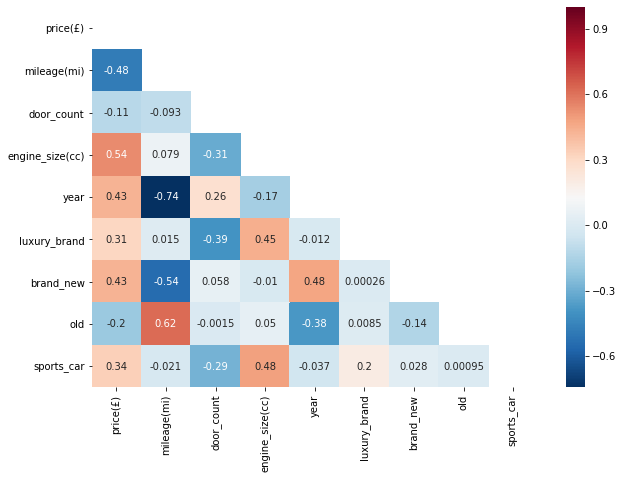

In [5]:
# Correlation matrix
heat_map(df, (10,7))

Features explained:

__Target__
1. Price - This is the price of the car in pounds sterling

__Predictors__
1. __Mileage__ - number of miles on cars odometer
2. __door_count__ - number of doors the car has. This number is inclusive of trunks that have access to the main cabin of the car (so hatchbacks and estates).
3. __engine_size__ - number of cubic centimeter capacity of each car cylinder
4. __year__ - year of registration
5. __luxury_brand__ - car brands considered luxury (1 = yes, 0 = no)
6. __brand_new__ - cars that have less than 10,000 miles on odometer (1 = yes, 0 = no)
7. __old__ - cars that have more than 100,000 on odometer (1 = yes, 0= no)
8. __brand__ - the make of the car
9. __transmission__ - the engine gearbox type automatic or manual
10. __body_style__ - body style of the car ex coupe, saloon, estate.
11. __model__ - the cars model within its brand that distinguishes it.
12. __sports_car__ - coupe body style and engine size > 2500cc (1 = yes, 0 = no)

## One-hot encode categoricals
In order to model with categorical values, that contain more than 2 categories, I need to encode the values. Encoding just provides a numeric value that represents the variables. For example: RGB (red, green, blue), red in this example would be encoded as `1/0/0`, blue would be encoded as `0/0/1`, and green would be encoded as `0/1/0`.

In [6]:
# View our data set
df.head()

,price(£),mileage(mi),door_count,body_style,engine_size(cc),transmission,year,brand,model,luxury_brand,brand_new,old,sports_car
0,19998,21249.0,5.0,Estate,1995.0,Automatic,2016.0,BMW,X1,1,0,0,0
1,17795,24468.0,5.0,Estate,1997.0,Automatic,2014.0,Honda,CR-V,0,0,0,0
2,14500,45793.0,5.0,Estate,1984.0,Automatic,2013.0,Audi,Q3,1,0,0,0
3,21499,5295.0,5.0,Estate,1598.0,Manual,2019.0,Kia,Optima,0,1,0,0
4,22975,33891.0,5.0,Estate,2967.0,Automatic,2016.0,Volkswagen,Touareg,0,0,0,0


In [7]:
# create the dummy variables
dummies = pd.get_dummies(df[['body_style', 'brand', 'transmission', 'model']], drop_first=True)
dummies.shape

(9578, 513)

In [8]:
# dropped the categoricals
altered_df = df.loc[:,['price(£)', 'mileage(mi)', 'door_count', 'engine_size(cc)', 'year']]

# combine the dummys with the other predictors
modeling_df = pd.concat([altered_df, dummies], axis=1)

In [9]:
modeling_df.head()

,price(£),mileage(mi),door_count,engine_size(cc),year,body_style_Convertible,body_style_Coupe,body_style_Estate,body_style_Hatchback,body_style_MPV,...,model_Xsara,model_Yaris,model_Yeti,model_Ypsilon,model_Z3,model_Z4,model_ZOE,model_ZS,model_Zafira,model_i8
0,19998,21249.0,5.0,1995.0,2016.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17795,24468.0,5.0,1997.0,2014.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14500,45793.0,5.0,1984.0,2013.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21499,5295.0,5.0,1598.0,2019.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22975,33891.0,5.0,2967.0,2016.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print("Modeling dataframe shape:",modeling_df.shape)

Modeling dataframe shape: (9578, 518)


In [11]:
# Target 
X = modeling_df.drop(axis=1, columns=['price(£)'])

# Predictors
y = modeling_df.loc[:,['price(£)']]
print('----------------------')
print('X Shape:', X.shape)
print('y Shape:', y.shape)
print('----------------------')

----------------------
X Shape: (9578, 517)
y Shape: (9578, 1)
----------------------


## Baseline modeling

In this section, I will be setting up my train,test, validation set. I will then fit different regressors (without hyper parameter optimization) and see how they perform.

### Train, test, validation split

In [12]:
# split data set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1000, random_state=17)
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train,y_train, test_size =1000, random_state=17)

In [13]:
# check the shape
print("----------train sets----------")
print('X_train Shape:', 'Rows',X_train.shape[0], 'Columns', X_train.shape[1])
print('y_train Shape:', 'Rows', y_train.shape[0], 'Columns', y_train.shape[1])
print("----------test sets-----------")
print('X_test Shape:', 'Rows', X_test.shape[0], 'Columns', X_test.shape[1])
print('y_test Shape:', 'Rows', y_test.shape[0], 'Columns', y_test.shape[1])
print("-------validation sets---------")
print('X_train_v Shape:', 'Rows',X_train_v.shape[0], 'Columns', X_train_v.shape[1])
print('y_train_v Shape:', 'Rows', y_train_v.shape[0], 'Columns', y_train_v.shape[1])
print('X_val Shape:', 'Rows', X_val.shape[0], 'Columns', X_val.shape[1])
print('y_val Shape:', 'Rows', y_val.shape[0], 'Columns', y_val.shape[1])
print("------------------------------")
print("Numbers add up: \n", 'train&test:',(X_train.shape[0]+y_train.shape[0])/2+(X_test.shape[0]+y_test.shape[0])/2==len(modeling_df))
print("train_v&val:", (X_train_v.shape[0]+y_train_v.shape[0])/2+(X_val.shape[0]+y_val.shape[0])/2+(X_test.shape[0]+y_test.shape[0])/2==len(modeling_df))
print("------------------------------")

----------train sets----------
X_train Shape: Rows 8578 Columns 517
y_train Shape: Rows 8578 Columns 1
----------test sets-----------
X_test Shape: Rows 1000 Columns 517
y_test Shape: Rows 1000 Columns 1
-------validation sets---------
X_train_v Shape: Rows 7578 Columns 517
y_train_v Shape: Rows 7578 Columns 1
X_val Shape: Rows 1000 Columns 517
y_val Shape: Rows 1000 Columns 1
------------------------------
Numbers add up: 
 train&test: True
train_v&val: True
------------------------------


## Baseline Linear Regression

In [14]:
# assign model to variable
baseline_regressor1 = LinearRegression()

# fit model to train and learn patterns
baseline_regressor1.fit(X_train_v, y_train_v)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
view_scores([baseline_regressor1], X_train_v, y_train_v, X_val, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,LinearRegression,0.87,-6.4446e+09,3.46784e+07,2.0051e+18,3302.88,1.03729e+08


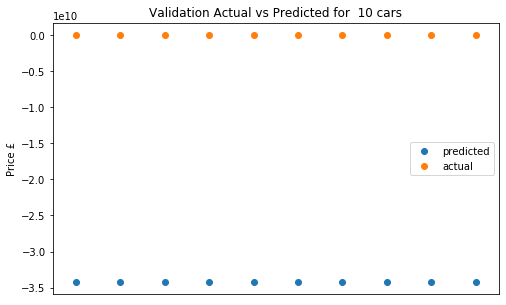

In [16]:
# Val plotting of 10 results
base_val_pred =baseline_regressor1.predict(X_val[20:30].round(-3))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.arange(10), base_val_pred, label='predicted')
ax.scatter(np.arange(10), y_val[20:30], label='actual')
ax.legend()
ax.set_title('Validation Actual vs Predicted for  10 cars')
ax.set_ylabel('Price £')
ax.set_xticks([])
# save output to figures folder
plt.savefig('../figures/baseline_predicted_output.png')

## Feature Engineering

It is very evident that my model feature is giving my learner a hard time. There is just too much deviation and it's hard to derive a pattern. I will drop this column from my data sets

In [17]:
columns_to_drop=[]

for column in X_train.columns:
    if "model" in column:
        columns_to_drop.append(column)

In [18]:
X_train.shape

(8578, 517)

In [19]:
# drop model feature
X_train_feature_eng = X_train.drop(axis=1, columns=columns_to_drop)
X_test_feature_eng = X_test.drop(axis=1, columns=columns_to_drop)
X_train_v_feature_eng = X_train_v.drop(axis=1, columns=columns_to_drop)
X_val_feature_eng = X_val.drop(axis=1, columns=columns_to_drop)

In [20]:
X_train_feature_eng.shape

(8578, 64)

## Run the regression again

### Scale

In [21]:
# instantiate scaler
scaler = StandardScaler()

# fit the train set only to learn the patterns 
scaler.fit(X_train_v_feature_eng)


X_train_v = scaler.transform(X_train_v_feature_eng)
X_val = scaler.transform(X_val_feature_eng)

X_train = scaler.transform(X_train_feature_eng) 
X_test = scaler.transform(X_test_feature_eng)

In [22]:
# assign model to variable
baseline_regressor = LinearRegression()

# fit model to train and learn patterns
baseline_regressor.fit(X_train_v_feature_eng, y_train_v)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
view_scores([baseline_regressor], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,LinearRegression,0.77,0.78,5.85697e+07,6.96629e+07,4449.81,4543.62


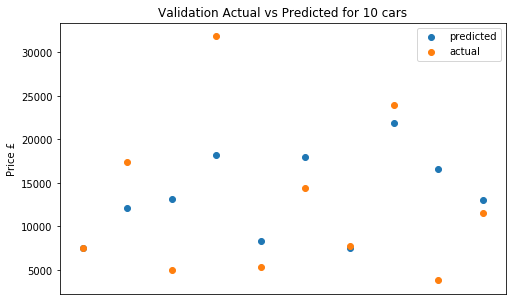

In [24]:
# Val plotting of 10 results
y_val_fe_pred =baseline_regressor.predict(X_val_feature_eng[20:30].round(-3))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.arange(10), y_val_fe_pred, label='predicted')
ax.scatter(np.arange(10), y_val[20:30], label='actual')
ax.legend()
ax.set_title('Validation Actual vs Predicted for 10 cars')
ax.set_ylabel('Price £')
ax.set_xticks([])
# save output to figures folder
plt.savefig('../figures/baseline_predicted_output.png')

This is better it seems like regular linear regression can't handle the model column.

### Decision tree Regressor Baseline

In [25]:
tree_regressor = DecisionTreeRegressor(max_depth=10)
tree_regressor.fit(X_train_v_feature_eng, y_train_v)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
view_scores([tree_regressor], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,DecisionTreeRegressor,0.95,0.85,1.31399e+07,4.71676e+07,2344.45,3433.65


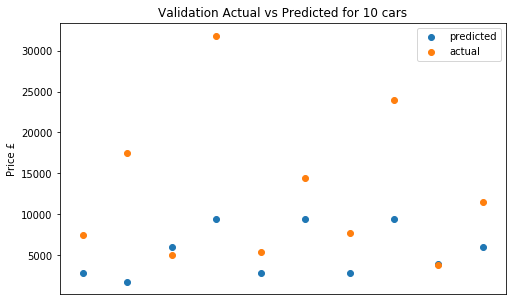

In [27]:
# Val plotting of 10 results
tree_pred =tree_regressor.predict(X_val_feature_eng[20:30].round(-3))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.arange(10), tree_pred, label='predicted')
ax.scatter(np.arange(10), y_val[20:30], label='actual')
ax.legend()
ax.set_title('Validation Actual vs Predicted for 10 cars')
ax.set_ylabel('Price £')
ax.set_xticks([])
# save output to figures folder
plt.savefig('../figures/dt_predicted_output.png')

## Random forrest regressor

In [28]:
forrest = RandomForestRegressor(n_estimators=200)
forrest.fit(X_train_v_feature_eng, y_train_v)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [29]:
view_scores([forrest], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51


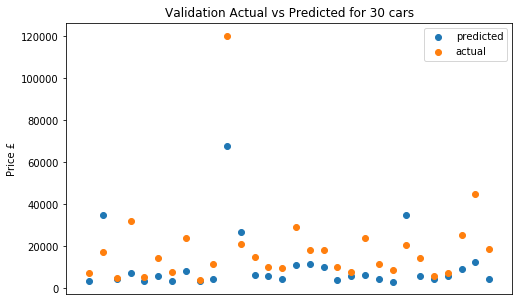

In [30]:
# Val plotting of 10 results
forest_pred = forrest.predict(X_val_feature_eng[20:50].round(-3))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.arange(30), forest_pred, label='predicted')
ax.scatter(np.arange(30), y_val[20:50], label='actual')
ax.legend()
ax.set_title('Validation Actual vs Predicted for 30 cars')
ax.set_ylabel('Price £')
ax.set_xticks([])
# save output to figures folder
plt.savefig('../figures/forrest_predicted_output.png')

## KNN regressor

In [31]:
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train_v_feature_eng, y_train_v)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [32]:
view_scores([neigh], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,KNeighborsRegressor,0.83,0.62,4.38024e+07,1.17461e+08,3799.63,5871.97


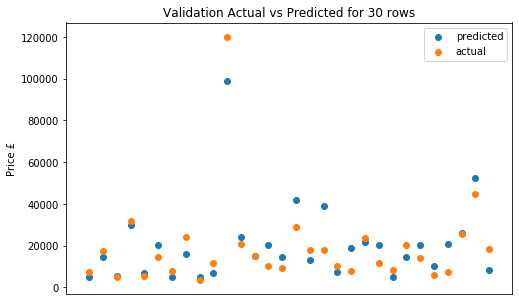

In [33]:
# Val plotting of 10 results
knn_pred =neigh.predict(X_val_feature_eng[20:50].round(-3))

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(np.arange(30), knn_pred, label='predicted')
ax.scatter(np.arange(30), y_val[20:50], label='actual')
ax.legend()
ax.set_title('Validation Actual vs Predicted for 30 rows')
ax.set_ylabel('Price £')
ax.set_xticks([])
# save output to figures folder
plt.savefig('../figures/Knn_predicted_output.png')

## Comparing models
In this section I will be comparing my models scores using a function I created taking into account high Validation r squared. I will also be randomizing and plotting the predictions vs actual multiple times to see how well each model does. 


In [34]:
# list all the instantiated above models
models =  [baseline_regressor, tree_regressor, forrest, neigh]

view_scores(models, X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)


,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
2,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51
1,DecisionTreeRegressor,0.95,0.85,1.31399e+07,4.71676e+07,2344.45,3433.65
0,LinearRegression,0.77,0.78,5.85697e+07,6.96629e+07,4449.81,4543.62
3,KNeighborsRegressor,0.83,0.62,4.38024e+07,1.17461e+08,3799.63,5871.97


The RandomForestRegressor seems to have performed the best across all metrics. Random forrests can be quite hard to interpret. Lets see how the predictions went by graphing some.

,price(£),Predicted Price(£),mileage(mi),door_count,engine_size(cc),year,brand,model,transmission,body_style
0,"9,950","3,370.74","94,000.0",5.0,"1,995.0",2016.0,BMW,3,Automatic,Estate
1,"10,999","6,287.3","17,978.0",5.0,"1,596.0",2017.0,Ford,B-MAX,Automatic,MPV
2,"16,298","5,117.84","53,681.0",5.0,"2,179.0",2014.0,Land-Rover,Range,Automatic,Hatchback
3,"8,999","4,064.41","76,723.0",5.0,"1,685.0",2014.0,Kia,Sportage,Manual,Estate
4,"3,650","4,268.56","94,000.0",4.0,"2,987.0",2005.0,Mercedes-Benz,CLS,Automatic,Coupe
5,"7,698","4,604.5","58,823.0",5.0,"1,560.0",2014.0,Volvo,V40,Manual,Hatchback
6,"13,991","35,663.36",151.0,5.0,1.0,2020.0,Smart,Forfour,Automatic,Hatchback
7,"8,995","4,171.98","65,841.0",5.0,"1,997.0",2014.0,Ford,Kuga,Automatic,4x4
8,"24,998","26,957.29","3,113.0",2.0,"1,991.0",2017.0,Mercedes-Benz,C,Automatic,Coupe
9,"17,999","6,108.62","24,700.0",4.0,"2,100.0",2016.0,Mercedes-Benz,C,Automatic,Saloon


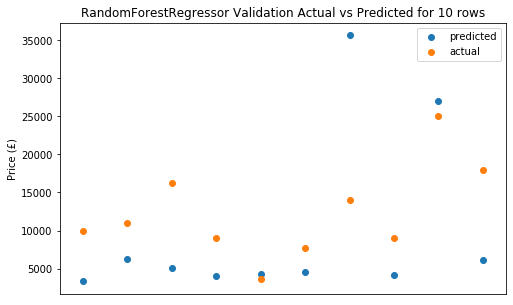

In [35]:
# random 10 predictions run this cell multiple times to randomize predictions

# Random Forrest Regressor
prediction_plotter(forrest, df, X_val_feature_eng, y_val)

There seems to be quite a large gap on some predictions lets see how the other regressors did.

,price(£),Predicted Price(£),mileage(mi),door_count,engine_size(cc),year,brand,model,transmission,body_style
0,"7,990","6,421.67","51,000.0",5.0,"1,560.0",2014.0,Citroen,C4,Automatic,MPV
1,"24,480","18,147.67","23,800.0",5.0,"2,000.0",2016.0,Land-Rover,Discovery-Sport,Automatic,Estate
2,"7,495","6,265.0","39,000.0",5.0,"1,388.0",2012.0,Ford,B-MAX,Manual,MPV
3,"3,995","6,593.0","53,200.0",5.0,"1,398.0",2013.0,Vauxhall,Meriva,Manual,MPV
4,"27,500","13,426.67","52,825.0",4.0,"2,979.0",2016.0,Maserati,Quattroporte,Automatic,Saloon
5,"36,650","38,282.67","27,000.0",4.0,"4,395.0",2015.0,BMW,X6,Automatic,Coupe
6,"12,699","5,663.0","68,864.0",4.0,"1,995.0",2016.0,BMW,5,Automatic,Saloon
7,"10,999","4,713.67","85,600.0",5.0,"2,360.0",2013.0,Toyota,Estima,Manual,MPV
8,"33,550","34,433.33","4,995.0",5.0,"2,199.0",2019.0,Hyundai,Santa,Automatic,4x4
9,"187,450","108,978.33",900.0,2.0,"3,996.0",2020.0,Bentley,Continental,Automatic,Convertible


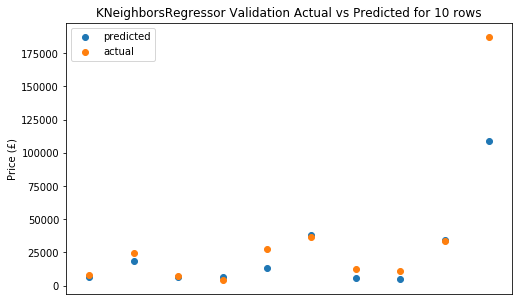

In [36]:
# random 10 predictions run this cell multiple times to randomize predictions

# KNN regressor
prediction_plotter(neigh, df, X_val_feature_eng, y_val)

I ran this cell multiple times, and each time I ran it, I found for the most part, the predictions were close with a few off. I like this model's predictions a lot more overall.

,price(£),Predicted Price(£),mileage(mi),door_count,engine_size(cc),year,brand,model,transmission,body_style
0,"39,995","9,443.03","7,031.0",5.0,"2,967.0",2019.0,Volkswagen,Touareg,Automatic,4x4
1,"17,450","5,927.56","55,893.0",2.0,"2,776.0",2011.0,Jeep,Wrangler,Automatic,Convertible
2,"14,299","9,443.03","10,131.0",3.0,"1,984.0",2017.0,Volkswagen,Scirocco,Manual,Coupe
3,"7,495","2,793.81","47,041.0",5.0,"1,300.0",2014.0,Honda,Jazz,Automatic,Hatchback
4,989,"2,793.81","41,000.0",5.0,"1,388.0",2004.0,Mazda,2,Manual,Hatchback
5,"11,980","3,837.66","100,000.0",4.0,"1,999.0",2016.0,Jaguar,XF,Automatic,Saloon
6,"17,975","9,443.03","32,363.0",4.0,"2,967.0",2016.0,Audi,A4,Automatic,Saloon
7,"29,500","9,443.03","14,955.0",5.0,"1,999.0",2019.0,Land-Rover,Discovery-Sport,Automatic,4x4
8,"9,490","5,927.56","76,000.0",4.0,"1,995.0",2015.0,BMW,3,Manual,Saloon
9,"28,980","9,443.03","5,607.0",5.0,"2,993.0",2019.0,BMW,4,Automatic,Coupe


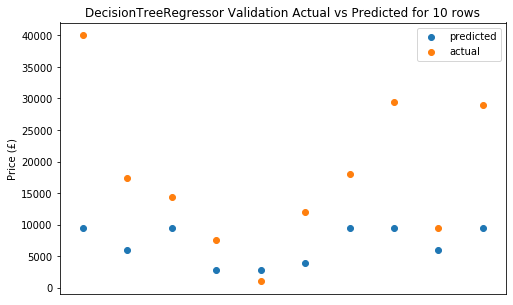

In [37]:
# random 10 predictions run this cell multiple times to randomize predictions

# Decision tree Regressor
prediction_plotter(tree_regressor, df, X_val_feature_eng, y_val)

,price(£),Predicted Price(£),mileage(mi),door_count,engine_size(cc),year,brand,model,transmission,body_style
0,"16,999","14,477.24","49,034.0",5.0,"1,798.0",2017.0,Toyota,C-HR,Automatic,Coupe
1,"13,000","15,642.02","37,183.0",5.0,"1,956.0",2017.0,Vauxhall,Zafira,Automatic,MPV
2,"169,949","39,851.08","2,707.0",2.0,"5,200.0",2018.0,Lamborghini,Huracan,Automatic,Coupe
3,"7,999","18,651.03","6,500.0",5.0,"1,600.0",2017.0,Kia,Venga,Automatic,MPV
4,"13,598","8,769.47","35,822.0",5.0,"1,496.0",2016.0,BMW,2,Manual,MPV
5,"3,295","14,574.31","48,462.0",5.0,"1,599.0",2009.0,Hyundai,Matrix,Automatic,MPV
6,"12,998","15,836.15","35,449.0",4.0,"1,999.0",2015.0,Jaguar,XE,Manual,Saloon
7,"6,512","13,991.92","54,287.0",5.0,"1,560.0",2014.0,Peugeot,2008,Manual,Estate
8,"13,270","9,837.18","24,881.0",5.0,"1,496.0",2016.0,BMW,2,Manual,MPV
9,"12,298","19,020.24","73,845.0",4.0,"2,993.0",2013.0,BMW,3,Automatic,Saloon


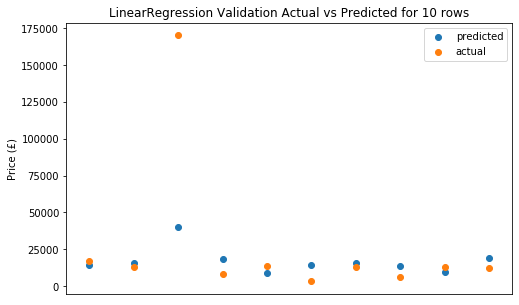

In [38]:
# random 10 predictions run this cell multiple times to randomize predictions

# Linear Regression
prediction_plotter(baseline_regressor, df, X_val_feature_eng, y_val)

Based off the predictions and scores I am quite interested in the KNN and Random Forrest Regressors. I will do some hyper parameter optimization using gridsearch and make my selection from there.

## Grid Search 
I will be utilizing sci kit learns GridSearchCV module, to automate the process of hyper parameter optimization.

### Setting up the grids
These are dictionaries of parameters I am able to change in my model.

In [39]:
# View params
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [40]:
# View params
KNeighborsRegressor().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## Set up Cross Validation

K folds will allow my grid search to train the data by splitting it into multiple folds and validating it based on that. By doing this, it will provide a train and validation score.

In [41]:
# Cross validation
skf = StratifiedKFold(n_splits=5, random_state=140)

### KNN regressor

There aren't too many parameters to tweak for this model.

In [42]:
%%time
# set up param grid
param_range = range(6,10)

neigh_grid = {'leaf_size': param_range,
              'n_neighbors': range(1,15),
              'leaf_size': param_range,
              'metric': ['minkowski', 'manhattan']}

# instatiate search
neigh_gs = GridSearchCV(neigh, neigh_grid, cv=skf)

# fit instatiation to train
neigh_gs.fit(X_train_v_feature_eng, y_train_v)

CPU times: user 33.3 s, sys: 983 ms, total: 34.3 s
Wall time: 54.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=140, shuffle=False),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=3, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': range(6, 10),
                         'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 15)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [43]:
neigh_gs.best_params_

{'leaf_size': 6, 'metric': 'manhattan', 'n_neighbors': 11}

In [44]:
neigh_gs.best_score_

0.6971111767020595

In [45]:
# compare original with gridsearch
view_scores([neigh_gs, neigh], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)


,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,GridSearchCV,0.75,0.7,6.43084e+07,9.30094e+07,4550.08,5228.97
1,KNeighborsRegressor,0.83,0.62,4.38024e+07,1.17461e+08,3799.63,5871.97


We definitely see some improvement from the hyper parameter optimization. Less error and higher R-squared on the validation sets.

### Random Forrest Regressor

In [46]:
%%time

#The param grid
forrest_grid={'max_depth':range(10,51, 5), 'min_samples_leaf':[5,50,500]}

# instatiate the gridsearch
rfr_gs = GridSearchCV(forrest, forrest_grid, cv=skf, return_train_score=True )

# fit to train
rfr_gs.fit(X_train_v_feature_eng, y_train_v)

CPU times: user 5min 37s, sys: 6.07 s, total: 5min 43s
Wall time: 7min 27s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=140, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                      

In [47]:
print("gridsearch best score:",rfr_gs.best_score_)
print("gridsearch best params:",rfr_gs.best_params_)

gridsearch best score: 0.8398656306559911
gridsearch best params: {'max_depth': 40, 'min_samples_leaf': 5}


In [48]:
rfr_gs.best_score_

0.8398656306559911

In [49]:
view_scores([rfr_gs, forrest], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
1,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51
0,GridSearchCV,0.91,0.85,2.33595e+07,4.66548e+07,2278.95,3169.77


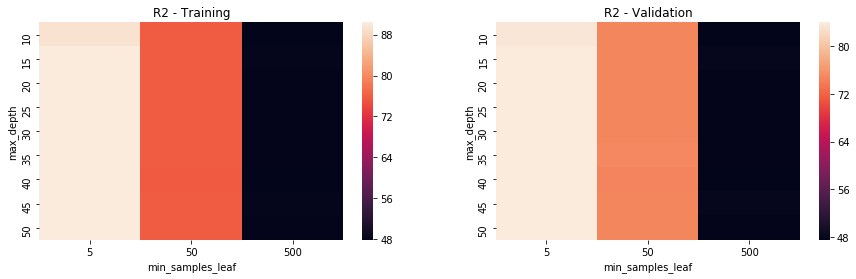

In [50]:
# View area to narrow down param ranges
grid_optimizer(rfr_gs)

### Change parameters and run again

In [51]:
%%time

#The param grid
forrest_grid={'max_depth':range(10,15), 'min_samples_leaf':range(1,36,2)}

# instatiate the gridsearch
rfr_gs2 = GridSearchCV(forrest, forrest_grid, cv=skf, return_train_score=True )

# fit to train
rfr_gs2.fit(X_train_v_feature_eng, y_train_v)

CPU times: user 22min 13s, sys: 22 s, total: 22min 35s
Wall time: 28min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=140, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=None,
                                      

In [52]:
print("gridsearch best score:",rfr_gs2.best_score_)
print("gridsearch best params:",rfr_gs2.best_params_)

gridsearch best score: 0.8672899709532942
gridsearch best params: {'max_depth': 14, 'min_samples_leaf': 1}


In [53]:
view_scores([rfr_gs2, forrest], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,GridSearchCV,0.97,0.89,7.52729e+06,3.55981e+07,1616.69,2860.93
1,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51


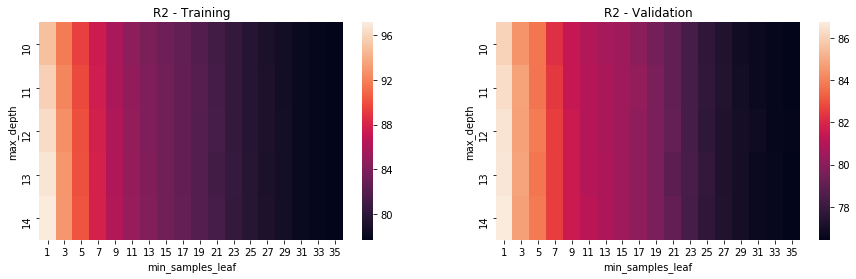

In [54]:
grid_optimizer(rfr_gs2)

it seems the optimal parameters for min_samples_leaf is 1 and the max_depth is 12

## Model Selection

In this section I will compare my gridsearched hyper parameter optimized models with my previous vanilla models. I will then select the model I want to use, train it on my final train set, and test it on my final test sets.

In [55]:
# original models
view_scores(models, X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
2,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51
1,DecisionTreeRegressor,0.95,0.85,1.31399e+07,4.71676e+07,2344.45,3433.65
0,LinearRegression,0.77,0.78,5.85697e+07,6.96629e+07,4449.81,4543.62
3,KNeighborsRegressor,0.83,0.62,4.38024e+07,1.17461e+08,3799.63,5871.97


Random Forest Regressor scored highest here.

### Compare Random forrest to KNN

In [56]:
gs_models = [rfr_gs2, neigh_gs]
# Table of the models
view_scores(gs_models, X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)
# 0 Randomforest
# 1 KNN

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,GridSearchCV,0.97,0.89,7.52729e+06,3.55981e+07,1616.69,2860.93
1,GridSearchCV,0.75,0.7,6.43084e+07,9.30094e+07,4550.08,5228.97


Random forrest still scored higher than KNN after param optimization. This time the mse went down a little bit in comparison to the vanilla models.

### Comparing Gridsearched Random forrest to Vanilla

In [57]:
view_scores([rfr_gs2, forrest], X_train_v_feature_eng, y_train_v, X_val_feature_eng, y_val)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,GridSearchCV,0.97,0.89,7.52729e+06,3.55981e+07,1616.69,2860.93
1,RandomForestRegressor,0.98,0.89,4.70013e+06,3.52883e+07,1040.73,2837.51


Gridsearch random forest wins.

In [58]:
# Select final model
final_model = rfr_gs2.best_estimator_

Based on higher R2 and lower mse from validation, I decided to select my Random forest regressor as my main model.

## Final test
In this section, I will be conducting my final test with my selected model. I will fit to X_train and run my model on X_test.

### Chosen model: KNN regressor

In [60]:
# Fit on train
final_neigh = neigh_gs.best_estimator_
final_neigh.fit(X_train_feature_eng, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=6, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                    weights='uniform')

In [61]:
# View final knn score on test
view_scores([final_neigh], X_train_feature_eng, y_train, X_test_feature_eng, y_test)

,Method,Train R2,Validation R2,Train MSE,Validation MSE,Train MAE,Validation MAE
0,KNeighborsRegressor,0.76,0.69,6.46833e+07,5.61277e+07,4558.64,4528.89


### Running Predictions
My function allows you to view 10 random cars from my test data set and uses the model to make predictions on these cars. Since it's completely randomized, you can keep rerunning the cell to get another 10 random cars and visualize it's predictions vs its actual.

,price(£),Predicted Price(£),mileage(mi),door_count,engine_size(cc),year,brand,model,transmission,body_style
0,"5,735","4,843.91","91,411.0",2.0,"1,995.0",2010.0,BMW,3,Manual,Convertible
1,"33,000","22,902.91","38,348.0",5.0,"3,000.0",2016.0,Land-Rover,Discovery,Automatic,4x4
2,"26,990","27,438.45","5,963.0",5.0,"1,969.0",2019.0,Volvo,V90,Manual,4x4
3,"12,450","10,147.73","70,000.0",5.0,"2,967.0",2012.0,Audi,A6,Automatic,Estate
4,"44,900","46,528.0","24,502.0",5.0,"4,400.0",2017.0,BMW,X5,Automatic,Estate
5,"72,850","41,664.36","25,754.0",2.0,"5,935.0",2010.0,Aston-Martin,DBS,Automatic,Convertible
6,"8,499","7,199.09","33,462.0",5.0,"1,364.0",2015.0,Vauxhall,Zafira,Manual,MPV
7,"17,000","11,908.45","13,709.0",4.0,"1,400.0",2015.0,Audi,A3,Automatic,Saloon
8,"16,995","22,043.82","39,716.0",2.0,"3,387.0",2007.0,Porsche,Cayman,Automatic,Coupe
9,"9,995","4,890.36","168,000.0",5.0,"3,630.0",2007.0,Land-Rover,Range-Rover-Sport,Automatic,4x4


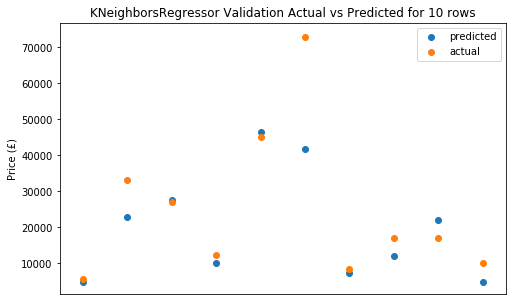

In [62]:
# View KNN regressor final model randomized predictions (run this cell many times for randomized guesses)
prediction_plotter(final_neigh, df, X_test_feature_eng, y_test)

#### Save the model

In [63]:
# dest = os.path.join('Car_Regressors', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)
    
# pickle.dump(final_neigh,
#            open(os.path.join(dest, 'KnnRegressor.pkl'), 'wb'),
#            protocol=4)

## Test conclusion

The model still has a lot of improvements to be made. If I was to improve it, I would web scrape other auto websites and increase my features. I would also provide a more balanced car brand selection within my data set as a whole. Since my data set was mostly comprised on Mercedes, BMW, and Audi, by random chance. <br>

I have the option to do that by just running my webscrapping script again.